**Uso del modelo con AR(1) donde el conjunto de test son todos registros del 2022**

In [1]:
import pandas as pd
#from google.colab import drive
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Conv1D, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE,ADASYN,KMeansSMOTE

from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer


from tensorflow.keras.callbacks import EarlyStopping
#import shap


In [2]:
def balanced_accuracy(y_true, y_pred):





    tp = sum((y_true == 1) & (y_pred == 1))  # True Positives
    tn = sum((y_true == 0) & (y_pred == 0))  # True Negatives
    fp = sum((y_true == 0) & (y_pred == 1))  # False Positives
    fn = sum((y_true == 1) & (y_pred == 0))  # False Negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    balanced_accuracy = (sensitivity + specificity) / 2

    return balanced_accuracy

In [3]:

ruta='../../data/'


df_final = pd.read_csv(ruta+'dfFinal.csv')



In [4]:
df_final

,ID,año,AC,Endeudamiento,FondoManiobra,PT,R,RAGXFI,RAIE,Solvencia,Zombi,SECTOR,RANGO_INGRESOS,EMPLEADOS,EDAD_EMPRESA,TIPOSOC
0,2.331510e+05,0.000000,0.023913,0.453292,0.476216,0.358907,0.476216,0.001411,0.040485,0.080816,0.0,6,5,39.0,51,7
1,2.331510e+05,0.083333,0.026300,0.463274,0.471618,0.355629,0.471618,0.001411,0.043602,0.064498,0.0,6,5,39.0,51,7
2,2.331510e+05,0.166667,0.030259,0.488989,0.473764,0.355992,0.473764,0.001411,0.052536,0.059908,0.0,6,5,39.0,51,7
3,2.331510e+05,0.250000,0.038109,0.507304,0.499606,0.359846,0.499606,0.001411,0.056812,0.059818,0.0,6,5,39.0,51,7
4,2.331510e+05,0.333333,0.022514,0.481316,0.475650,0.360398,0.475650,0.007388,0.046632,0.103046,1.0,6,5,39.0,51,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159453,2.121895e+10,0.666667,0.063454,0.424169,0.596856,0.395630,0.596856,0.030379,0.027967,0.187216,0.0,11,4,9.0,15,7
159454,2.121895e+10,0.750000,0.070663,0.425968,0.554215,0.422019,0.554215,0.030379,0.013401,0.202884,0.0,11,4,9.0,15,7
159455,2.121895e+10,0.833333,0.076286,0.425156,0.535840,0.460604,0.535840,0.030379,0.013814,0.215780,0.0,11,4,9.0,15,7
159456,2.121895e+10,0.916667,0.092759,0.421266,0.652722,0.517823,0.652722,0.030379,0.025238,0.642806,0.0,11,4,9.0,15,7


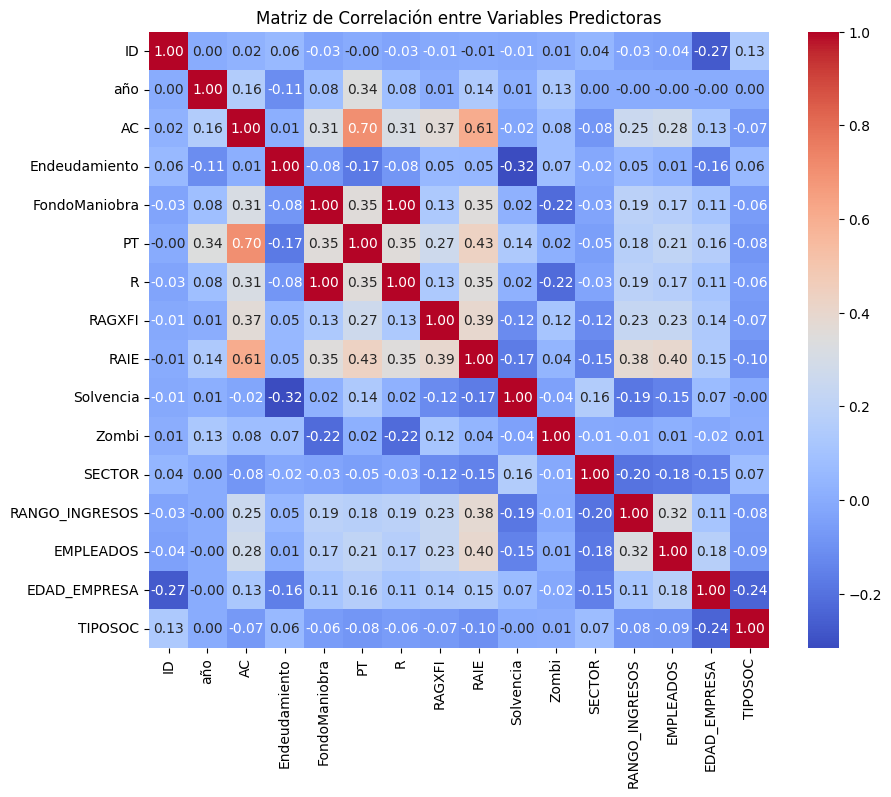

Correlación con el target:
 ID                0.007487
año               0.130138
AC                0.078996
Endeudamiento     0.074954
FondoManiobra    -0.221241
PT                0.015062
R                -0.221241
RAGXFI            0.115723
RAIE              0.036480
Solvencia        -0.042605
Zombi             1.000000
SECTOR           -0.010722
RANGO_INGRESOS   -0.013219
EMPLEADOS         0.014999
EDAD_EMPRESA     -0.016315
TIPOSOC           0.007735
dtype: float64


In [5]:
#Estudio de correlación
correlaciones =df_final.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables Predictoras")
plt.show()

# correlación con el target
correlacion_con_target = df_final.corrwith(df_final['Zombi'])
print("Correlación con el target:\n", correlacion_con_target)

In [6]:
df_final.drop('FondoManiobra', axis=1, inplace=True) # se quita por que son los mismo datos que los de "resultados"

In [7]:
# introducir en cada fila el valor zombi del año pasado para esa empresa

df_final.sort_values(by=['ID', 'año'], inplace=True)
df_final['ZombiPrevio'] = df_final.groupby('ID')['Zombi'].shift(1)
df_final['ZombiPrevio'] = df_final['ZombiPrevio'].fillna(0)

df_final['ACPrevio'] = df_final.groupby('ID')['AC'].shift(1)
df_final['ACPrevio'] = df_final['ACPrevio'].fillna(df_final['ACPrevio'].mean())

df_final['EndeudamientoPrevio'] = df_final.groupby('ID')['Endeudamiento'].shift(1)
df_final['EndeudamientoPrevio'] = df_final['EndeudamientoPrevio'].fillna(df_final['EndeudamientoPrevio'].mean())

df_final['PTPrevio'] = df_final.groupby('ID')['PT'].shift(1)
df_final['PTPrevio'] = df_final['PTPrevio'].fillna(df_final['PTPrevio'].mean())

df_final['RPrevio'] = df_final.groupby('ID')['R'].shift(1)
df_final['RPrevio'] = df_final['RPrevio'].fillna(df_final['RPrevio'].mean())

df_final['RAGXFIPrevio'] = df_final.groupby('ID')['RAGXFI'].shift(1)
df_final['RAGXFIPrevio'] = df_final['RAGXFIPrevio'].fillna(df_final['RAGXFIPrevio'].mean())

df_final['SolvenciaPrevia'] = df_final.groupby('ID')['Solvencia'].shift(1)
df_final['SolvenciaPrevia'] = df_final['SolvenciaPrevia'].fillna(df_final['SolvenciaPrevia'].mean())


In [8]:
df_final.isna().sum()

ID                     0
año                    0
AC                     0
Endeudamiento          0
PT                     0
R                      0
RAGXFI                 0
RAIE                   0
Solvencia              0
Zombi                  0
SECTOR                 0
RANGO_INGRESOS         0
EMPLEADOS              0
EDAD_EMPRESA           0
TIPOSOC                0
ZombiPrevio            0
ACPrevio               0
EndeudamientoPrevio    0
PTPrevio               0
RPrevio                0
RAGXFIPrevio           0
SolvenciaPrevia        0
dtype: int64

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159458 entries, 0 to 159457
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   159458 non-null  float64
 1   año                  159458 non-null  float64
 2   AC                   159458 non-null  float64
 3   Endeudamiento        159458 non-null  float64
 4   PT                   159458 non-null  float64
 5   R                    159458 non-null  float64
 6   RAGXFI               159458 non-null  float64
 7   RAIE                 159458 non-null  float64
 8   Solvencia            159458 non-null  float64
 9   Zombi                159458 non-null  float64
 10  SECTOR               159458 non-null  int64  
 11  RANGO_INGRESOS       159458 non-null  int64  
 12  EMPLEADOS            159458 non-null  float64
 13  EDAD_EMPRESA         159458 non-null  int64  
 14  TIPOSOC              159458 non-null  int64  
 15  ZombiPrevio      

In [10]:
df_final.head(10)

,ID,año,AC,Endeudamiento,PT,R,RAGXFI,RAIE,Solvencia,Zombi,...,EMPLEADOS,EDAD_EMPRESA,TIPOSOC,ZombiPrevio,ACPrevio,EndeudamientoPrevio,PTPrevio,RPrevio,RAGXFIPrevio,SolvenciaPrevia
0,233151.0,0.000000,0.023913,0.453292,0.358907,0.476216,0.001411,0.040485,0.080816,0.0,...,39.0,51,7,0.0,0.060493,0.485760,0.387451,0.488840,0.018598,0.128319
1,233151.0,0.083333,0.026300,0.463274,0.355629,0.471618,0.001411,0.043602,0.064498,0.0,...,39.0,51,7,0.0,0.023913,0.453292,0.358907,0.476216,0.001411,0.080816
2,233151.0,0.166667,0.030259,0.488989,0.355992,0.473764,0.001411,0.052536,0.059908,0.0,...,39.0,51,7,0.0,0.026300,0.463274,0.355629,0.471618,0.001411,0.064498
3,233151.0,0.250000,0.038109,0.507304,0.359846,0.499606,0.001411,0.056812,0.059818,0.0,...,39.0,51,7,0.0,0.030259,0.488989,0.355992,0.473764,0.001411,0.059908
4,233151.0,0.333333,0.022514,0.481316,0.360398,0.475650,0.007388,0.046632,0.103046,1.0,...,39.0,51,7,0.0,0.038109,0.507304,0.359846,0.499606,0.001411,0.059818
5,233151.0,0.416667,0.018757,0.475423,0.359969,0.471638,0.003831,0.021428,0.143310,0.0,...,39.0,51,7,1.0,0.022514,0.481316,0.360398,0.475650,0.007388,0.103046
6,233151.0,0.500000,0.025415,0.478861,0.359646,0.472171,0.000274,0.017839,0.082524,0.0,...,39.0,51,7,0.0,0.018757,0.475423,0.359969,0.471638,0.003831,0.143310
7,233151.0,0.583333,0.025115,0.437031,0.344837,0.482414,0.000158,0.020914,0.091303,0.0,...,39.0,51,7,0.0,0.025415,0.478861,0.359646,0.472171,0.000274,0.082524
8,233151.0,0.666667,0.025089,0.434540,0.345915,0.478409,0.000143,0.029336,0.101137,0.0,...,39.0,51,7,0.0,0.025115,0.437031,0.344837,0.482414,0.000158,0.091303
9,233151.0,0.750000,0.030902,0.445329,0.364152,0.478157,0.000264,0.021016,0.077522,0.0,...,39.0,51,7,0.0,0.025089,0.434540,0.345915,0.478409,0.000143,0.101137


In [11]:


# Preparar los datos para el modelo
feature_columns = [col for col in df_final.columns if  "Zombi" not in col and col != 'ID']


target_column="Zombi"

#X= df_final[feature_columns].values
#y = df_final[target_column].values

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train=df_final.loc[df_final['año'] != 1, feature_columns].values
y_train=df_final.loc[df_final['año'] != 1, target_column].values
X_test=df_final.loc[df_final['año'] == 1, feature_columns].values
y_test=df_final.loc[df_final['año'] == 1, target_column].values

# Verificar las dimensiones de los datos transformados y los predictores
(X_train.shape, X_test.shape,feature_columns)

((147192, 19),
 (12266, 19),
 ['año',
  'AC',
  'Endeudamiento',
  'PT',
  'R',
  'RAGXFI',
  'RAIE',
  'Solvencia',
  'SECTOR',
  'RANGO_INGRESOS',
  'EMPLEADOS',
  'EDAD_EMPRESA',
  'TIPOSOC',
  'ACPrevio',
  'EndeudamientoPrevio',
  'PTPrevio',
  'RPrevio',
  'RAGXFIPrevio',
  'SolvenciaPrevia'])

In [12]:
# Aplicar Oversampling
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5) #mejora el recall

smote = SMOTE(random_state=42)


#X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
(X_train.shape, X_test.shape)

((259662, 19), (12266, 19))

In [13]:


# Calcular el balance de clases para ajustar scale_pos_weight
# Es la relación del número de ejemplos negativos a los positivos
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model_XGBoost = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,  # Ajustar según el desequilibrio de clases
    max_depth=6,            # Profundidad del árbol, típicamente entre 3-10
    min_child_weight=1,     # El mínimo de sumas de pesos de instancias necesarias en un hijo
    gamma=0.3,              # Reducción mínima de la pérdida necesaria para hacer una división
    subsample=0.8,          # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,   # Fracción de características para entrenar cada árbol
    n_estimators=200,       # Número de árboles
    learning_rate=0.1       # Tasa de aprendizaje
)
model_XGBoost.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
# Definir el modelo y los parámetros para la búsqueda en cuadrícula
model_RF = RandomForestClassifier(


    max_depth=6,            # Profundidad del árbol, típicamente entre 3-10
    n_estimators=200,       # Número de árboles

)
model_RF.fit(X_train, y_train)



RandomForestClassifier(max_depth=6, n_estimators=200)

In [15]:

model_LTSM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_LTSM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_LTSM.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Usando el 20% de los datos de entrenamiento para validación
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
6492/6492 [==============================] - 102s 15ms/step - loss: 0.5628 - accuracy: 0.6784 - val_loss: 1.3856 - val_accuracy: 0.0908
Epoch 2/20
6492/6492 [==============================] - 86s 13ms/step - loss: 0.5327 - accuracy: 0.7091 - val_loss: 1.2591 - val_accuracy: 0.1041
Epoch 3/20
6492/6492 [==============================] - 88s 14ms/step - loss: 0.5087 - accuracy: 0.7367 - val_loss: 1.2180 - val_accuracy: 0.1380
Epoch 4/20
6492/6492 [==============================] - 85s 13ms/step - loss: 0.4751 - accuracy: 0.7638 - val_loss: 1.0636 - val_accuracy: 0.3039
Epoch 5/20
6492/6492 [==============================] - 80s 12ms/step - loss: 0.4500 - accuracy: 0.7828 - val_loss: 1.2275 - val_accuracy: 0.2061
Epoch 6/20
6492/6492 [==============================] - 81s 12ms/step - loss: 0.4311 - accuracy: 0.7954 - val_loss: 1.0756 - val_accuracy: 0.4128
Epoch 7/20
6492/6492 [==============================] - 80s 12ms/step - loss: 0.4078 - accuracy: 0.8109 - val_loss: 1.3946 

In [16]:


model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_CNN.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,  # Usando el 20% de los datos de entrenamiento para validación
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/20
6492/6492 [==============================] - 45s 7ms/step - loss: 0.6969 - accuracy: 0.6134 - val_loss: 1.4567 - val_accuracy: 0.0888
Epoch 2/20
6492/6492 [==============================] - 43s 7ms/step - loss: 0.6399 - accuracy: 0.6222 - val_loss: 1.4826 - val_accuracy: 0.0759
Epoch 3/20
6492/6492 [==============================] - 43s 7ms/step - loss: 0.6309 - accuracy: 0.6266 - val_loss: 1.5889 - val_accuracy: 0.0032
Epoch 4/20
6492/6492 [==============================] - 43s 7ms/step - loss: 0.6226 - accuracy: 0.6351 - val_loss: 1.5341 - val_accuracy: 0.0408
Epoch 5/20
6492/6492 [==============================] - 42s 6ms/step - loss: 0.6081 - accuracy: 0.6579 - val_loss: 1.3998 - val_accuracy: 0.0627
Epoch 6/20
6492/6492 [==============================] - 41s 6ms/step - loss: 0.5982 - accuracy: 0.6693 - val_loss: 1.5676 - val_accuracy: 0.0447
Epoch 7/20
6492/6492 [==============================] - 44s 7ms/step - loss: 0.5935 - accuracy: 0.6729 - val_loss: 1.5153 - val_ac

In [17]:
# Creación de un DataFrame para almacenar las métricas
df_metricas = pd.DataFrame(index=["XGBoost","RF", "LTSM","CNN"])

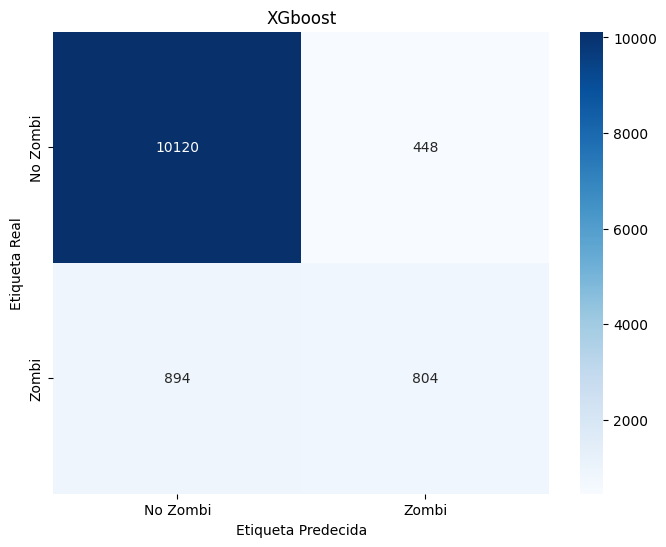

In [18]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_XGBoost.predict(X_test)


df_metricas.loc["XGBoost", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["XGBoost", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred)
df_metricas.loc["XGBoost", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["XGBoost", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["XGBoost", "F1 Score"] = f1_score(y_test,y_pred)




# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('XGboost')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

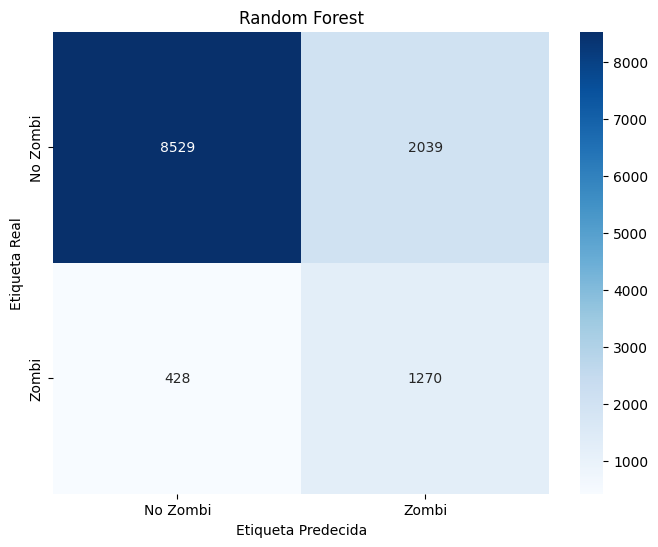

In [19]:
# Predecir las etiquetas para el conjunto de testeo
y_pred = model_RF.predict(X_test)

df_metricas.loc["RF", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["RF", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred)
df_metricas.loc["RF", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["RF", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["RF", "F1 Score"] = f1_score(y_test,y_pred)

# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

384/384 [==============================] - 3s 9ms/step


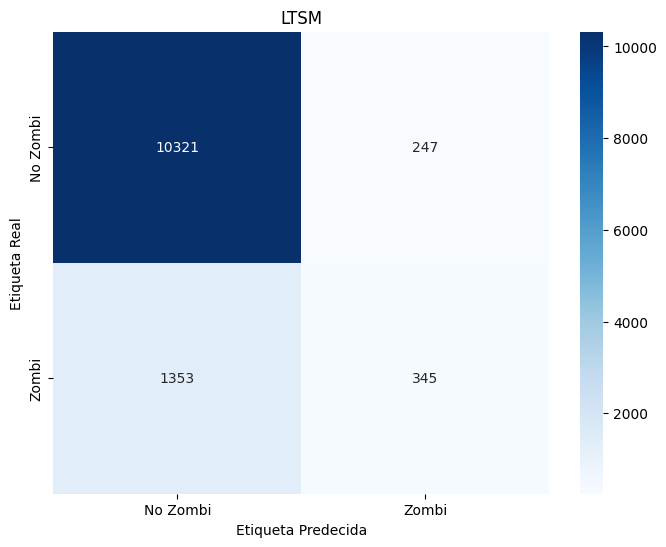

In [23]:
# Predecir las etiquetas para el conjunto de testeo

y_pred_probs = model_LTSM.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["LTSM", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["LTSM", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred.flatten())
df_metricas.loc["LTSM", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["LTSM", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["LTSM", "F1 Score"] = f1_score(y_test,y_pred)
# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('LTSM')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

384/384 [==============================] - 2s 6ms/step


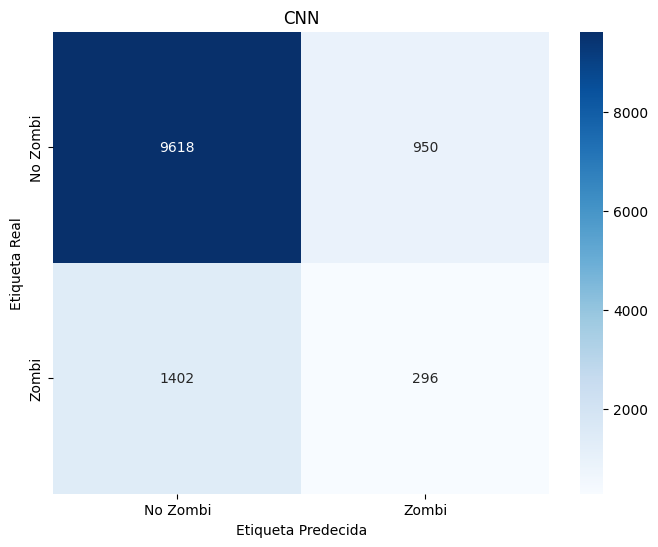

In [24]:
# Predecir las etiquetas para el conjunto de testeo
y_pred_probs = model_CNN.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

df_metricas.loc["CNN", "Accuracy"] =  accuracy_score(y_test, y_pred)
df_metricas.loc["CNN", "Balanced Accuracy"] = balanced_accuracy(y_test, y_pred.flatten())
df_metricas.loc["CNN", "Precision"] = precision_score(y_test, y_pred)
df_metricas.loc["CNN", "Recall"] = recall_score(y_test, y_pred)
df_metricas.loc["CNN", "F1 Score"] = f1_score(y_test,y_pred)

# Calcular la matriz de confusión TEST
conf_matrix = confusion_matrix(y_test, y_pred)


# Nombres de las clases para el heatmap
class_names = ['No Zombi', 'Zombi']

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas para claridad
plt.title('CNN')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predecida')

# Mostrar la visualización
plt.show()

In [25]:
df_metricas

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
XGBoost,0.890592,0.715553,0.642173,0.473498,0.545085
RF,0.798875,0.777499,0.383802,0.747939,0.507290
LTSM,0.869558,0.589904,0.582770,0.203180,0.301310
CNN,0.808250,0.542214,0.237560,0.174323,0.201087
